# Decision Trees

**Spring 2025 - Instructor:  Chris Volinsky**


**Original Notebooks courtesy of Prof. Foster Provost and Rubing Li**

***

## Some general imports

In [12]:
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pylab as plt
import seaborn as sns

%matplotlib inline
sns.set(style='ticks', palette='Set2')

## Predicting who will survive the Titanic

This time we will use a clasic introductory dataset that contains demographic and traveling information for the Titanic passengers. The goal is to predict the survival of these passengers. We will only keep a few variables of interest and transform all of them to numeric variables. We will also drop some outliers.

In [13]:
# Read in the data
# Download data to your local machine from this URL:
# https://drive.google.com/uc?export=download&id=1mJgS2IOvkmJLrnoVNSNcIz4e07V3wFwA

# read in data into data frame "df" - only the features we will use

df = pd.read_csv("titanic.csv")[["survived", "pclass", "sex", "age", "fare"]]
df.head()


,survived,pclass,sex,age,fare
0,1.0,1.0,female,29.0000,211.3375
1,1.0,1.0,male,0.9167,151.5500
2,0.0,1.0,female,2.0000,151.5500
3,0.0,1.0,male,30.0000,151.5500
4,0.0,1.0,female,25.0000,151.5500


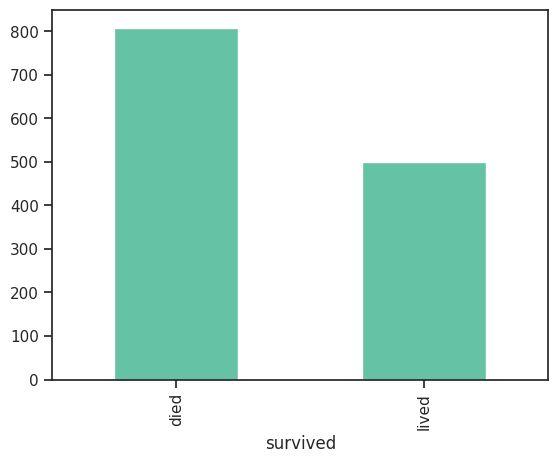

In [14]:
#replace "survived" with a categorical feature with values "lived" and "died"

df["survived"] = df["survived"].astype(bool)
df["survived"] = df["survived"].map({1.0: "lived", False: "died"})

# make a barplot of survived

df["survived"].value_counts().plot(kind="bar")
plt.show()

### Exploring the Titanic Data

In [15]:
# look at descriptives (note: only shows numeric)

df.describe()

,pclass,age,fare
count,1309.000000,1046.000000,1308.000000
mean,2.294882,29.881135,33.295479
std,0.837836,14.413500,51.758668
min,1.000000,0.166700,0.000000
25%,2.000000,21.000000,7.895800
50%,3.000000,28.000000,14.454200
75%,3.000000,39.000000,31.275000
max,3.000000,80.000000,512.329200


It looks like there might be some missing values of some of these variables, becasue they have different counts.  Let's confirm

In [16]:
na_count = df.isna().sum()

na_count

,0
survived,0
pclass,1
sex,1
age,264
fare,2


Wow.  There are a lot of missing values for the age variable.  We would want to check and see if the missing cases are different in any way.  For starters, are they more or less likely to die?  Lets check.


In [17]:
age_missing = df['age'].isnull()

print("Percent missing age",age_missing.mean().round(4))

survived_missing = df[age_missing]['survived'].value_counts()
survived_non_missing = df[~age_missing]['survived'].value_counts()

n_missing=survived_missing.sum()

print("\nAge Missing that Survived\n", (survived_missing/n_missing).round(3))

n_nonmissing=survived_non_missing.sum()

print("\nAge Non-Missing that Survived\n", (survived_non_missing/n_nonmissing).round(3))


Percent missing age 0.2015

Age Missing that Survived
 survived
died     0.72
lived    0.28
Name: count, dtype: float64

Age Non-Missing that Survived
 survived
died     0.592
lived    0.408
Name: count, dtype: float64


This is concerning.   In a more thorough analysis of this data, we would study the missing-ness more deeply to see if the missing values are correlated with other attributes, which would potentially add bias to the results.  Maybe we would try and dig deeper to collect the ages of the missing.  

One option is to simply impute the missing ages with the average age across the data set.  This is bett than removing the data.  A more sophisticated approach would be to try and model age from other features - for instance, we could assume someone spending over $100 is older.   

Let's do the simple imputation here.  In a careful analysis we would revisit this at the end of the analysis to see what impact this decision has on our final conclusions.


In [18]:
# impute missing values of age with the mean of age
mean_age=df["age"].mean()
df["age"] = df["age"].fillna(mean_age)

# there is also one missing value for fare.  Do the same for fare
mean_fare=df["fare"].mean()
df["fare"] = df["fare"].fillna(mean_fare)


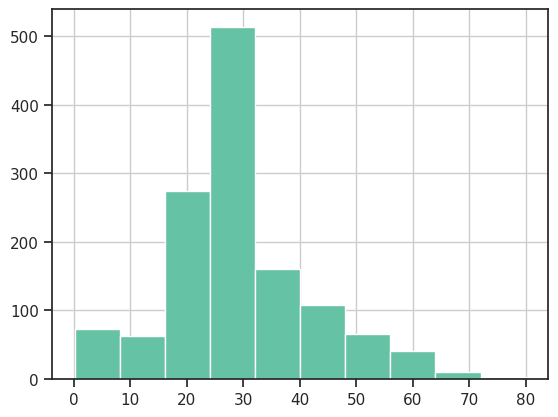

In [19]:
# print a histogram for age
df["age"].hist()
plt.show()

In [20]:
# finally, create a new feature, female, such that female passengers have female =1

df["female"] = df["sex"]
df["female"] = (df.sex == "female").astype(int)


We'd like to use data about the passengers to predict whether they will survive. Let's start by taking a look at how well some of the variables "split" the data according to our target.

In [21]:
# what is the *base rate* of survival?


survival = df["survived"].value_counts()/df["survived"].count()
print(survival.round(3))

survived
died     0.618
lived    0.382
Name: count, dtype: float64


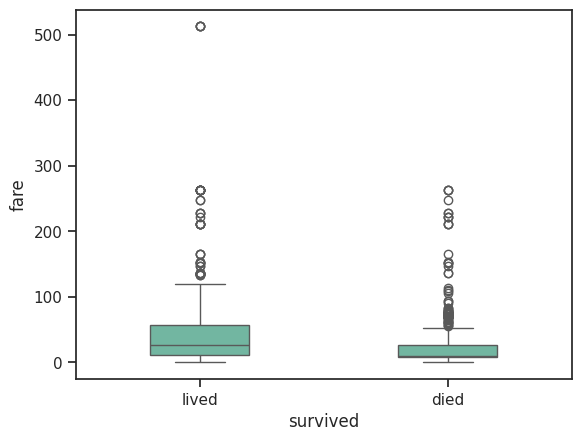

In [22]:
# do fares differ from those that survived from those who died?
# how do you interpret this?

sns.boxplot(x="survived", y="fare", width=0.4, data=df)
plt.show()

Above we see boxplots that show the fare distribution grouped by our target variable (survival). Alternatively, let's plot the distribution of fare according to survival:

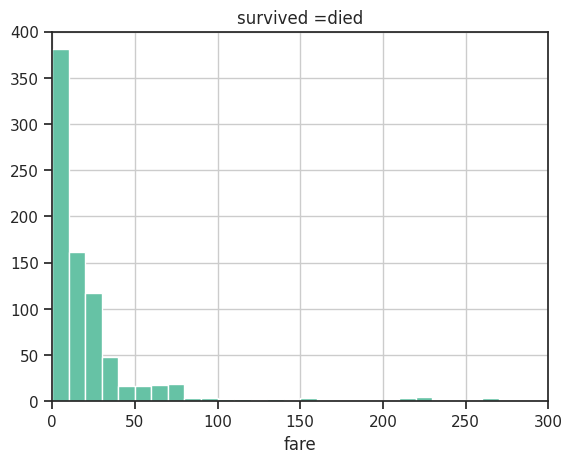

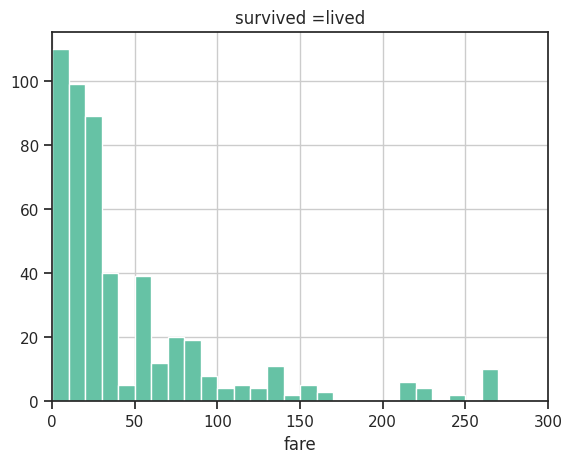

In [23]:
for r in ["died","lived"]:
    x_max=300 # maybe shrink to 300 to avoid outliers
    hist = df[df.survived == r].hist('fare',bins=range(0,x_max,10))
    plt.title("survived =" + str(r))
    # plt.ylim(0,300) # can use this to plot on same axes
    plt.xlabel("fare")
    plt.xlim([0,x_max])
    plt.show()

On might conclude from this that people that paid less are less likely to survive. **What do you think is a good split point?**. How effective is this threshold? Let's quantify it!

### Finding the best splits


**Entropy** ($H$) and **information gain** ($IG$) are useful tools for measuring the effectiveness of a split on the values of one variable for giving information on the value of another variable. Entropy measures how random data is, information gain is a measure of the reduction in randomness after performing a split.

We wrote Python functions to calculate entropy and information gain


In [24]:
def entropy(target_column):
    """
        computes -sum_i p_i * log_2 (p_i) for each i
    """
    # get the counts of each target value
    target_counts = target_column.value_counts().astype(float).values
    total = target_column.count()
    # compute probas
    probas = target_counts/total
    # p_i * log_2 (p_i)
    entropy_components = probas * np.log2(probas)
    # return negative sum
    return - entropy_components.sum()

def information_gain(df, info_column, target_column, threshold):
    """
        computes H(target) - H(target | info > thresh) - H(target | info <= thresh)
    """
    # split data
    data_above_thresh = df[df[info_column] > threshold]
    data_below_thresh = df[df[info_column] <= threshold]
    # get entropy
    H = entropy(df[target_column])
    entropy_above = entropy(data_above_thresh[target_column])
    entropy_below = entropy(data_below_thresh[target_column])
    # compute weighted average
    ct_above = data_above_thresh.shape[0]
    ct_below = data_below_thresh.shape[0]
    tot = float(df.shape[0])
    return H - entropy_above*ct_above/tot - entropy_below*ct_below/tot

Now that we have a way of calculating $H$ and $IG$, let's test our prior guess as a good split point as a split on fare allows us to predict people who will survive.

In [25]:
threshold = 250
prior_entropy = entropy(df["survived"])
IG = information_gain(df, "fare", "survived", threshold)
print ("IG of %.4f - using a threshold of %.2f - given a prior entropy of %.4f" % (IG, threshold, prior_entropy))

IG of 0.0078 - using a threshold of 250.00 - given a prior entropy of 0.9597


How good was our guess? Let's loop through all possible splits on fare and see what is the best!

In [26]:
def best_threshold(df, info_column, target_column, criteria=information_gain):
    maximum_ig = 0
    maximum_threshold = 0

    for thresh in df[info_column].unique():
        IG = criteria(df, info_column, target_column, thresh)
        if IG > maximum_ig:
            maximum_ig = IG
            maximum_threshold = thresh

    return (maximum_threshold, maximum_ig)

col = "fare"
maximum_threshold, maximum_ig = best_threshold(df, col, "survived")

print ("The best split threshold for %s is %.2f - which provides a maximum IG of %.4f." % (col, maximum_threshold, maximum_ig ))

The best split threshold for fare is 15.10 - which provides a maximum IG of 0.0586.


Other observed features may also give us (strong) clues about survival.

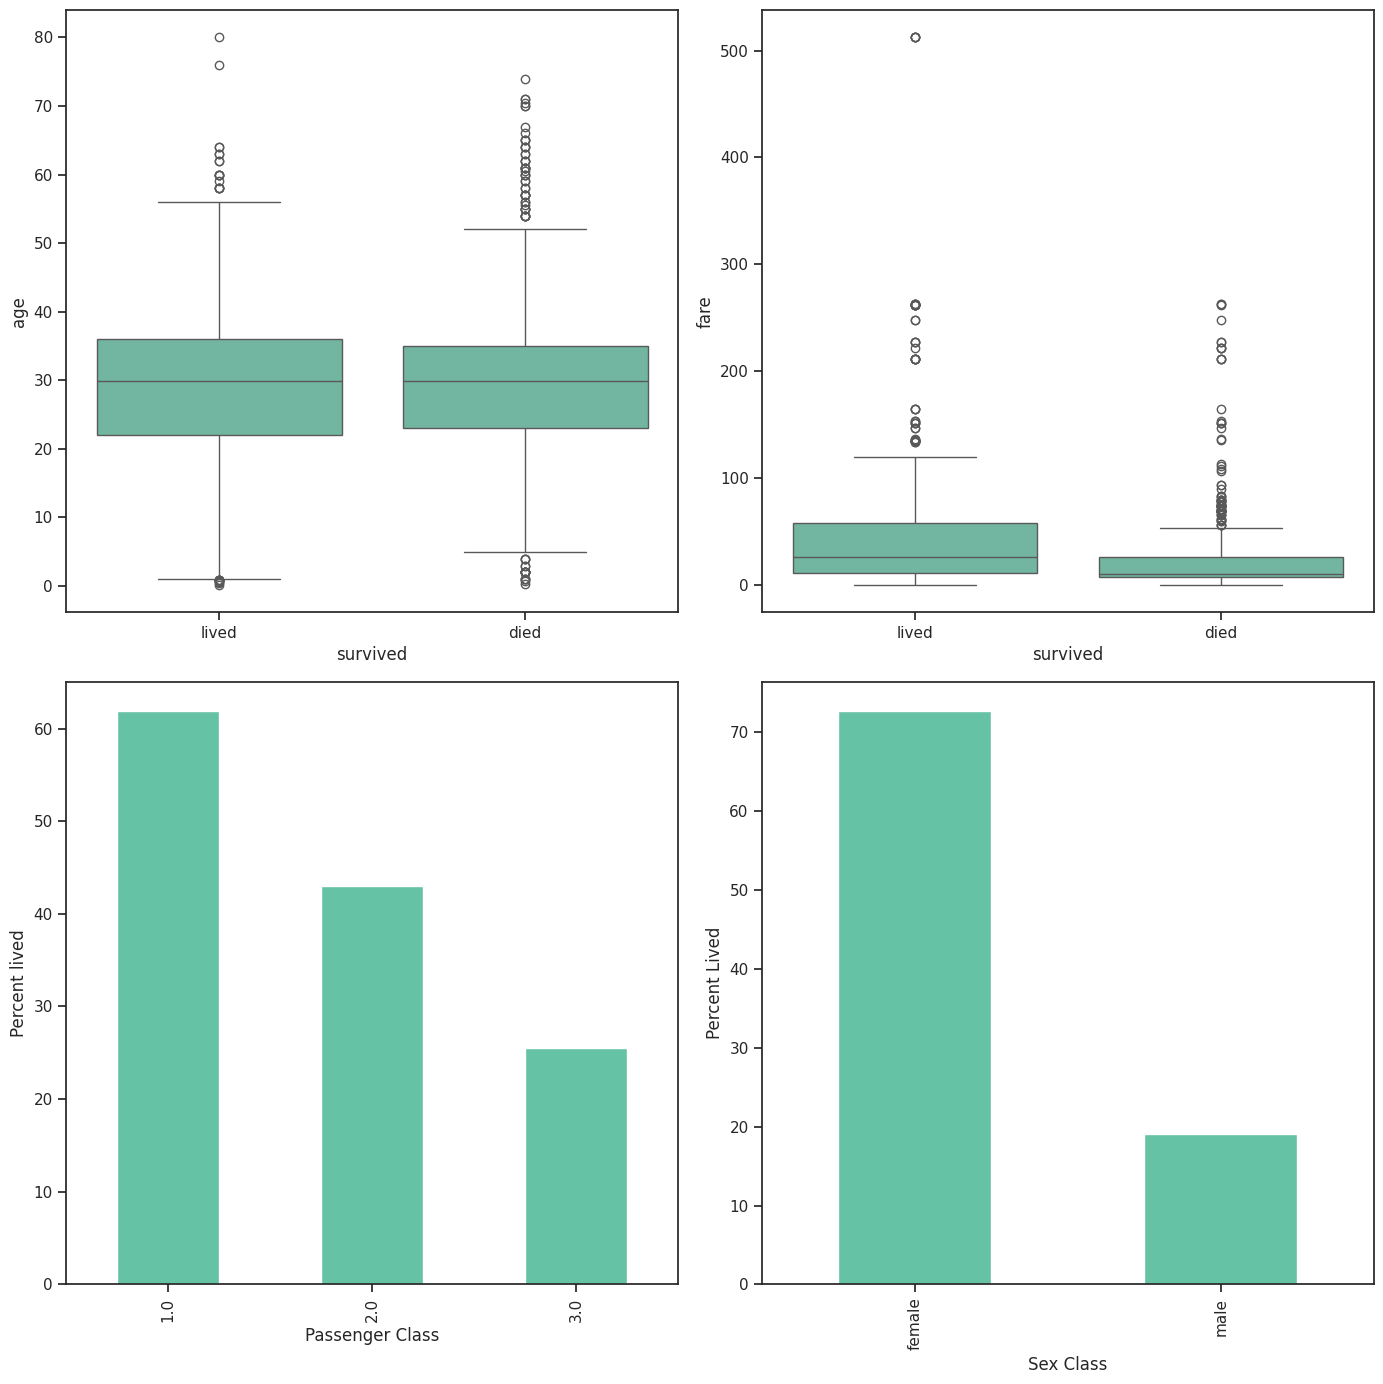

In [27]:
# Names of different columns
categorical_cols = ["pclass", "female"]
continuous_cols = ["age", "fare"]
target_col = "survived"
predictor_cols = categorical_cols + continuous_cols

# This is to plot everything in a 2x2 space
rows, cols = 2, 2
fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(7*cols, 7*rows))
axs = axs.flatten()
posn = 0

# Plot continous features
for col in continuous_cols:
    sns.boxplot(x=target_col, y=col, data=df, ax=axs[posn])
    axs[posn].set_ylabel(col)
    axs[posn].set_title("")
    posn += 1

# plots for cateogrical variables
pctlived = df.groupby('pclass')['survived'].value_counts(normalize=True)
pctlived = pctlived.unstack()*100
pctlived.index = pctlived.index.astype(str)
pctlived['lived'].plot(kind='bar',ax=axs[posn])
axs[posn].set_ylabel("Percent lived")
axs[posn].set_xlabel("Passenger Class")
axs[posn].set_title("")
posn +=1


pctlived = df.groupby('sex')['survived'].value_counts(normalize=True)
pctlived = pctlived.unstack()*100
pctlived.index = pctlived.index.astype(str)
pctlived['lived'].plot(kind='bar',ax=axs[posn])
axs[posn].set_ylabel("Percent Lived")
axs[posn].set_xlabel("Sex Class")
axs[posn].set_title("")


plt.tight_layout()

So, then ... what feature gives the most effective split?

In [28]:
def best_split(df, info_columns, target_column, criteria=information_gain):
    maximum_ig = 0
    maximum_threshold = 0
    maximum_column = ""

    for info_column in info_columns:
        thresh, ig = best_threshold(df, info_column, target_column, criteria)

        if ig > maximum_ig:
            maximum_ig = ig
            maximum_threshold = thresh
            maximum_column = info_column

    return maximum_column, maximum_threshold, maximum_ig

max_col, max_threshold, max_ig = best_split(df, predictor_cols, "survived")


print ("The best column to split on is %s giving us a IG of %.4f using a thresh of %.2f" % (max_col, max_ig, max_threshold))

The best column to split on is pclass giving us a IG of 0.9597 using a thresh of nan


### Using DecisionTreeClassifier

Of course, splitting the data one time sometimes isn't enough to make accurate predictions. However, we can continue to split the data recursively ("recursive partitioning"), building a tree-structured model that may give better results.


Thankfully we have software to determine the best split for us, instead of the brute force process above.  Let's use `sklearn`'s implementation which includes some additional functionality.

In [29]:
from sklearn.tree import DecisionTreeClassifier

# Define the model (tree)
decision_tree = DecisionTreeClassifier(max_depth=None, criterion="entropy")

# Fit the model
decision_tree.fit(df[predictor_cols], df["survived"])

DecisionTreeClassifier(criterion='entropy')

We now have a classification tree, let's visualize the results!

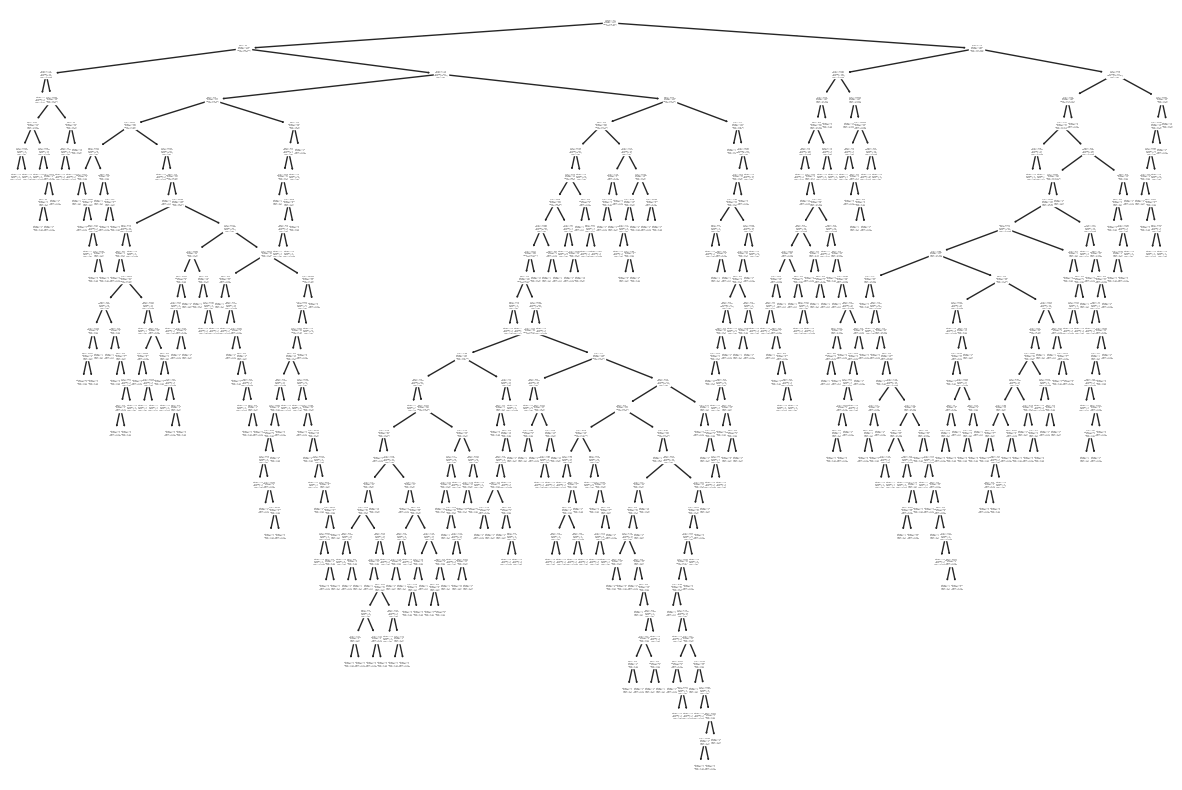

In [30]:
from sklearn.tree import plot_tree

plt.figure(figsize=(15,10))
plot_tree(decision_tree, feature_names=predictor_cols, class_names=["died", "survived"])
plt.show()

Whoa!  This will almost surely overfit!  We will see later how to protect against his...

Lets make things easier by setting max_depth to 3 - then visualize the tree and explore it to see what is important

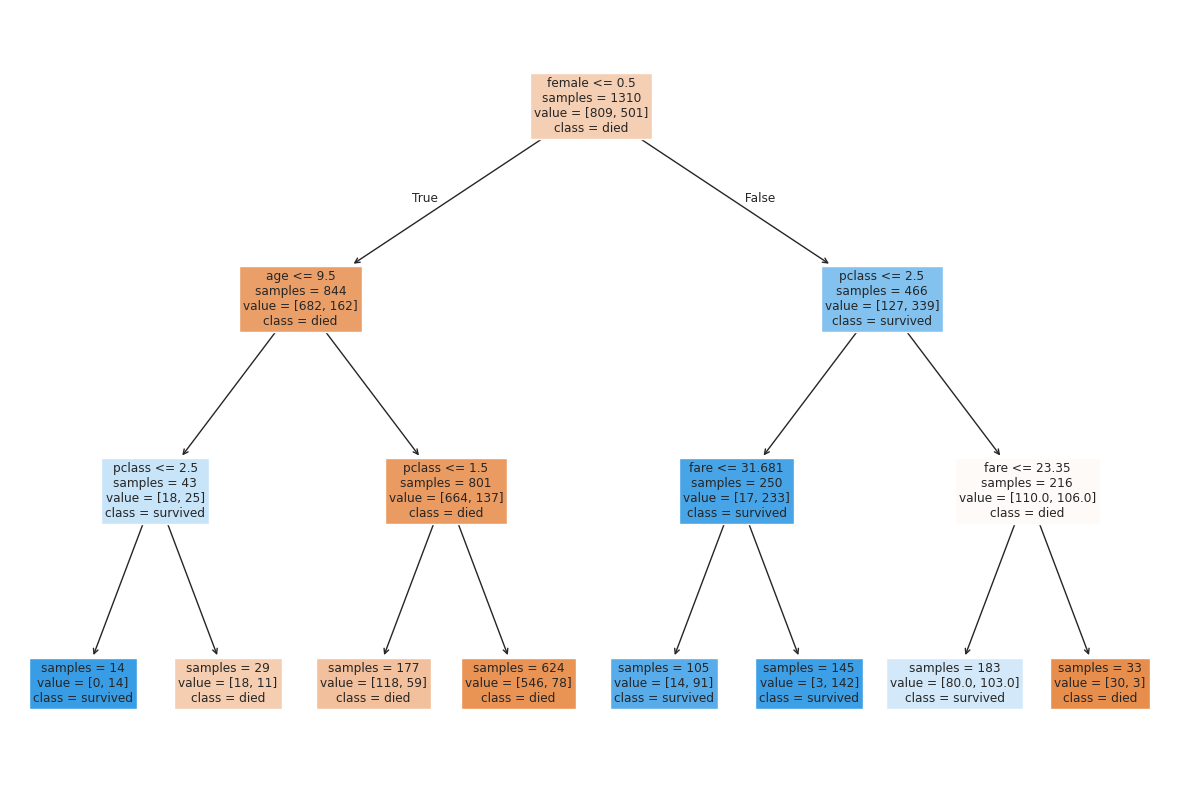

In [31]:
from sklearn import tree

decision_tree = DecisionTreeClassifier(max_depth=3, criterion="entropy")   # Look at those 2 arguments !!!

# Train the model on our X and y!
decision_tree.fit(df[predictor_cols], df["survived"])

plt.figure(figsize=(15,10))
tree.plot_tree(decision_tree, feature_names=predictor_cols, class_names=["died", "survived"],
               filled=True, impurity=False)
plt.show()


### Evaluating the model

How good is this model?  Calculate the accuracy - although we know this might not be the best metric*, it is still useful!!
It simply means the percent of cases that are correctly predicted in the leaf nodes of the tree.

* because it is not measured on a hold-out set
* need to compare it to base-rate

In [32]:
from sklearn import metrics
accuracy = metrics.accuracy_score(decision_tree.predict(df[predictor_cols]),df["survived"])
print ( "Accuracy = ", round(accuracy,4))

Accuracy =  0.8107


### Finding the Optimal Tree Size


Use the  function `train_test_split` from `sklearn` to create a training and test set with an 80/20 split.  Use a random_state argument to make sure you can run with the same split repeatedly.

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

### define X and y (as before)

X = df[predictor_cols]
y = df["survived"]

### create training and test sets
### CHOOSE YOUR OWN RANDOM STATE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)


In [34]:

### fit the model on the training set (use depth=2)
depth=4
decision_tree = DecisionTreeClassifier(max_depth=depth, criterion="entropy")
decision_tree.fit(X_train, y_train)

### apply the model to the test set using .predict
y_pred = decision_tree.predict(X_test)

### find the accuracy using metrics.accuracy_score()
accuracy = metrics.accuracy_score(y_pred, y_test)
print("Accuracy:", round(accuracy,4))

Accuracy: 0.7901


Is accuracy better on the training or the test data?  Why?

Now we will use our training/test split to help us determine what is the best depth for the tree.  There are various parameters we can use to prevent overfitting:

- `max_depth` -  how many layers to the tree
- `min_samples_split` - the minimum number of samples needed at a node to split (default =2)
- `min_samples_leaf` - the minimum number of samples that can be in a leaf node
- `max_leaf_nodes` - limits the number of leaf nodes in the overall tree
- `min_impurity_decrease` - restricts the ability of the tree to create trivial splits

Let's explore the depth of the tree, using `max-depth`

Using a for loop, fit trees to your training set of max_depth = [2,3,4,5,6] and report the accuracy on the test set for each.

What is YOUR optimal depth? (this might differ based on the `random_state` chosen)

Optional - change `random_state` and run again.

In [35]:
# Do this!

# create an list of numbers to cycle through values of max_depth from 2 to 10

# depth_vals = 1,2,3,4,5,6,7
depth_vals = np.arange(2,11)

for depth in depth_vals:

  decision_tree = DecisionTreeClassifier(max_depth=depth, criterion="entropy")

  # Tell the model what is the "training" data and then train it

  decision_tree.fit(X_train,y_train)

  y_pred = decision_tree.predict(X_test)

  accuracy = metrics.accuracy_score(y_pred,y_test)

  print("max_depth = ",depth,"Accuracy:", round(accuracy,4))

max_depth =  2 Accuracy: 0.7405
max_depth =  3 Accuracy: 0.7939
max_depth =  4 Accuracy: 0.7901
max_depth =  5 Accuracy: 0.7557
max_depth =  6 Accuracy: 0.7519
max_depth =  7 Accuracy: 0.7481
max_depth =  8 Accuracy: 0.7481
max_depth =  9 Accuracy: 0.7557
max_depth =  10 Accuracy: 0.7519


**Make sure to record your optimal `max_depth` and the accuracy to report in your Async Assessment!**


Once we know the optimal depth, if this were a real-world problem, before we apply it to the real world, we would re-fit our model to the FULL data set.  (This is a contrived case because there is no actual real-world application to predicting Titanic deaths 😱 ).  But lets do it anyway.


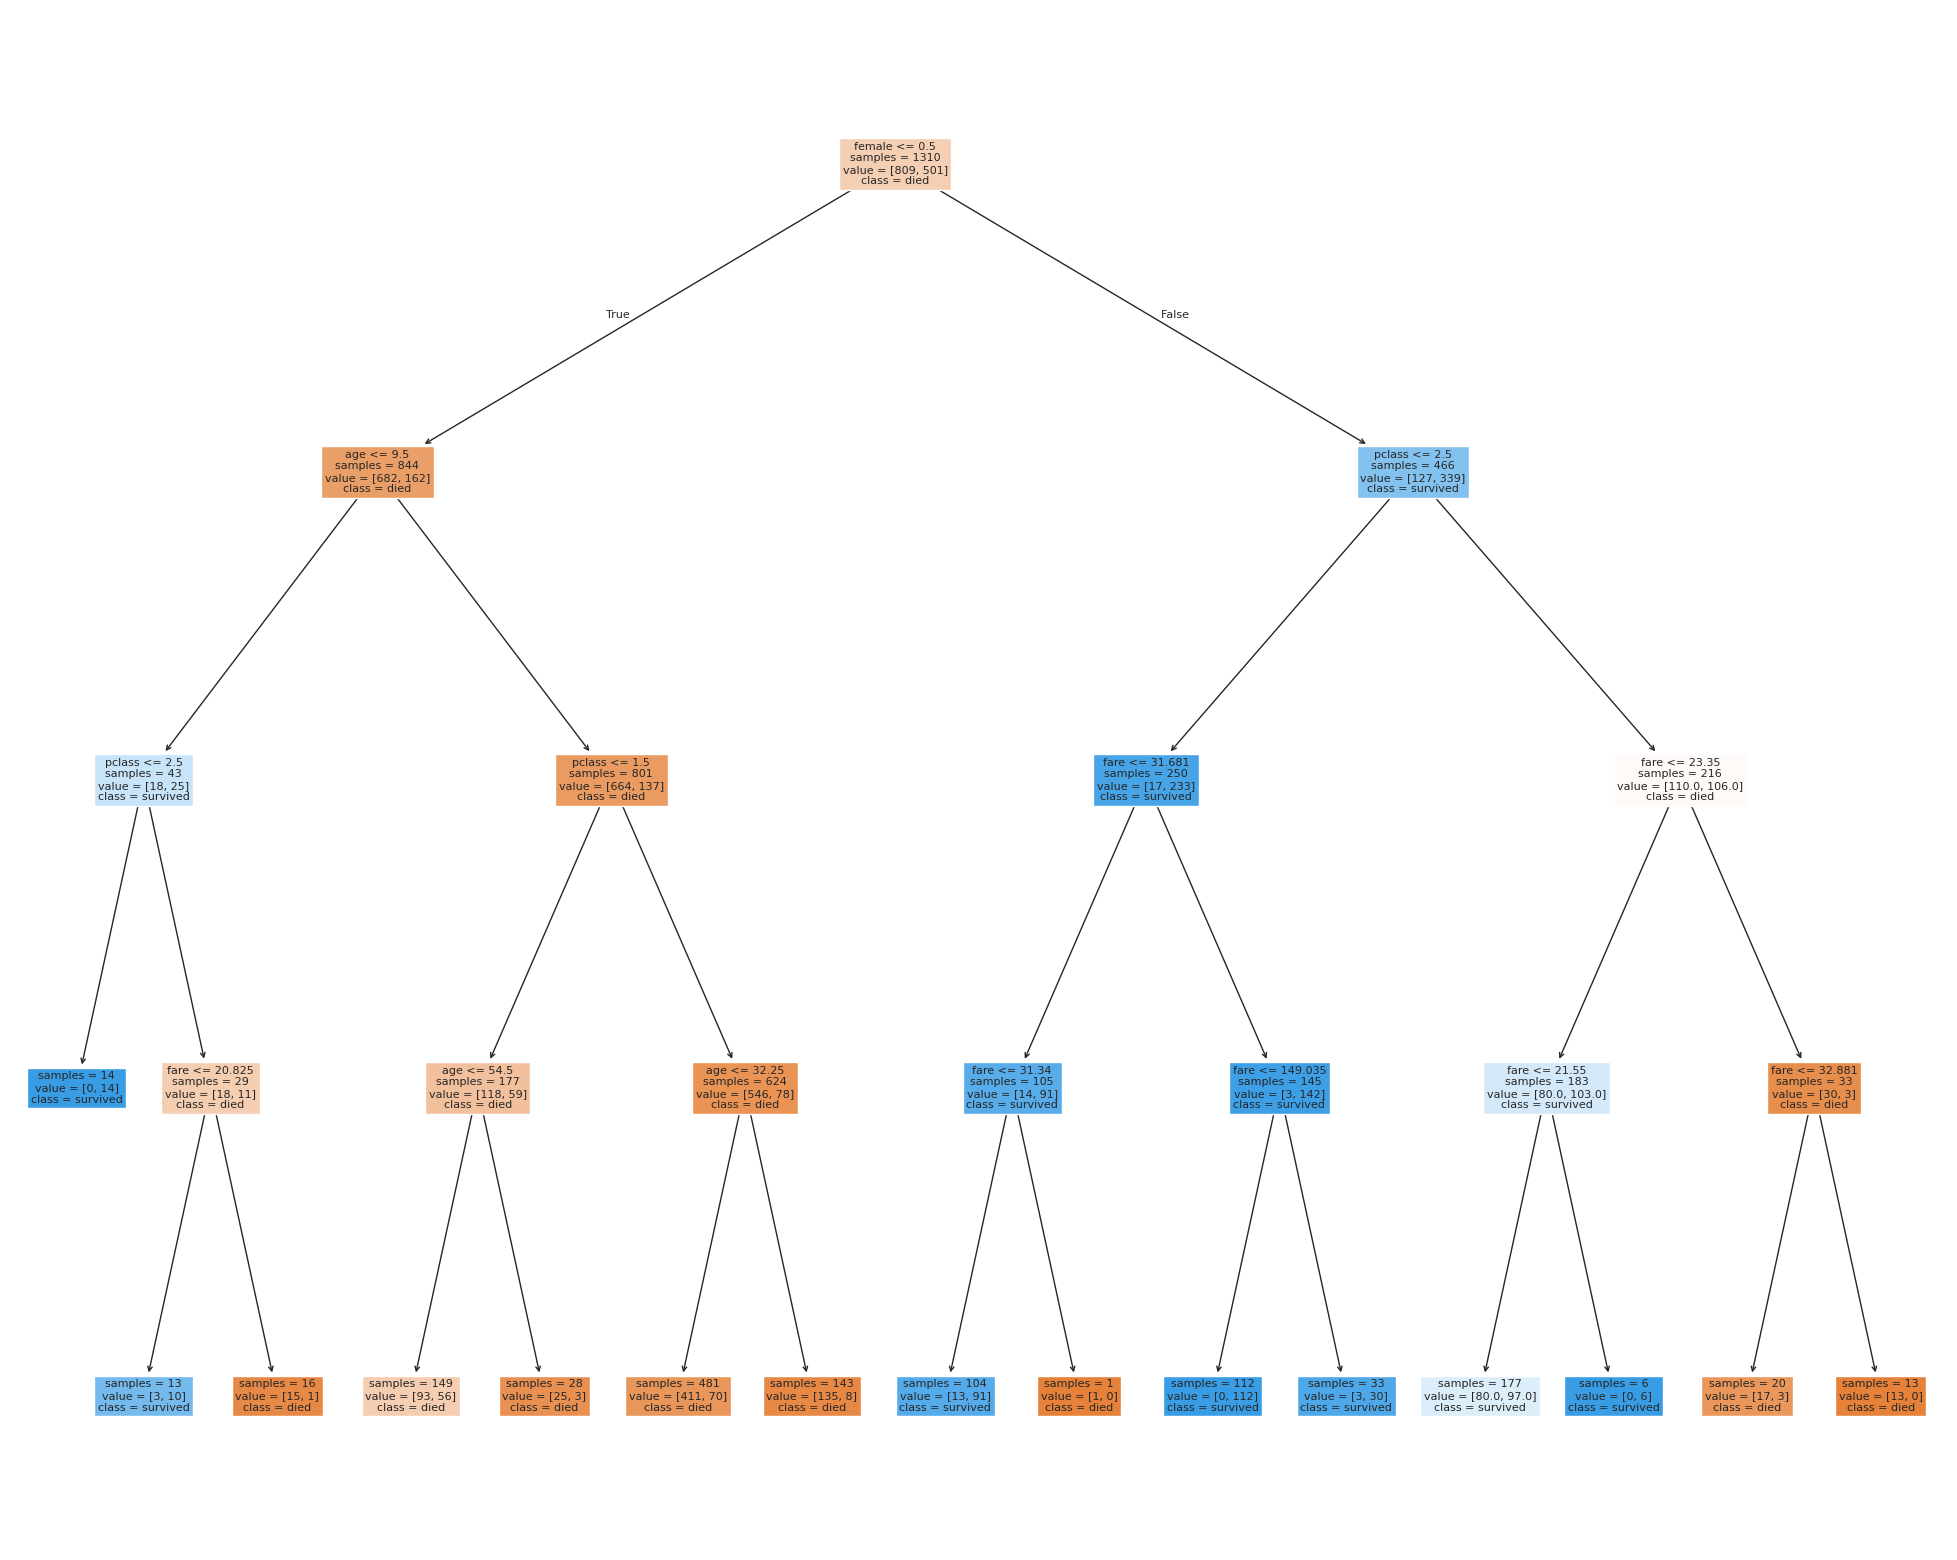

In [36]:
# now that we know the best max_depth, to find the best tree...apply it to the ENTIRE data set
# (aka use X and y instead of X_train and y_train)

opt_depth = 4 ##YOUR_OPT_DEPTH_VALUE##

tree_final = DecisionTreeClassifier(max_depth=opt_depth, criterion="entropy")
tree_final.fit(X,y)

plt.figure(figsize=(25,20))
tree.plot_tree(tree_final, feature_names=predictor_cols, class_names=["died", "survived"],filled=True, impurity=False)
plt.show()

You can use `.feature_importances_` applied to the tree model to get the importance (or Information Gain) of each feature.  Find the importances of the four attributes and plot as a barplot.

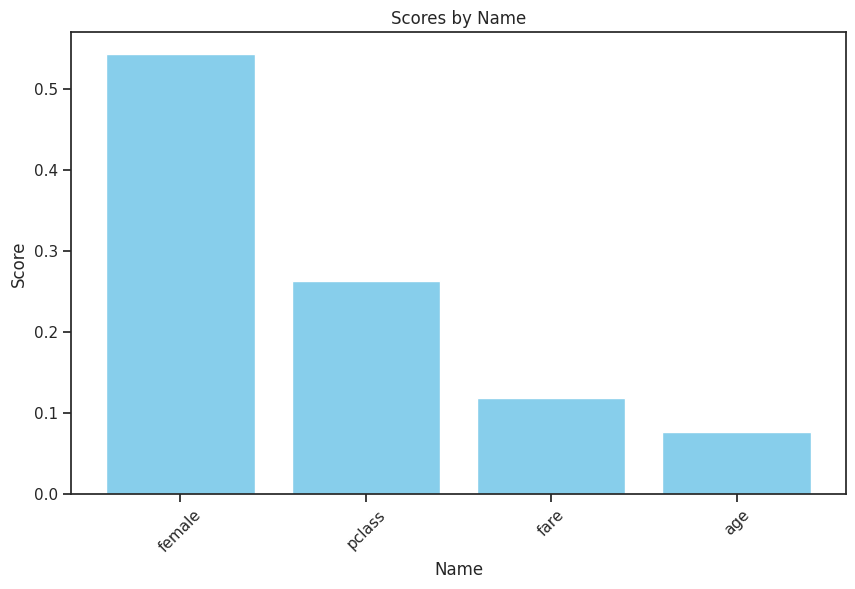

In [37]:
# find feature importances and plot

# print(predictor_cols, importances.round(4))

scores = tree_final.feature_importances_
names=predictor_cols


sorted_pairs = sorted(zip(scores, names), reverse=True)
sorted_scores, sorted_names = zip(*sorted_pairs)

# Create the bar plot
plt.figure(figsize=(10, 6))  # Optional: Adjust the figure size as needed
plt.bar(sorted_names, sorted_scores, color='skyblue')  # You can change the color

# Add title and labels
plt.title('Scores by Name')
plt.xlabel('Name')
plt.ylabel('Score')

# Display the plot
plt.xticks(rotation=45)  # Rotate names to prevent overlap
plt.show()

### Predicting Survival for new Passenger

Now we want to make a survival prediction for a specific passenger based on your model.   

Rose 👩 is a 26 year old female who paid $150 for her ticket, what is her survival percentage?  

**Record Rose's survival percentage for your model in the Async Assessment**

In [38]:
# Create a new data point for the prediction based on Rose's features - fill in the XX!!
# you must put the features in the same order that they are in the training set
rose = pd.DataFrame([[1,1,26,125]], columns=predictor_cols)

# Use the trained model to predict the survival probability
# The predict_proba method returns the probabilities for each class (Died, Survived)
survival_probabilities = tree_final.predict_proba(rose)

# Print the survival probabilities
# The columns in the output array correspond to the classes in tree_final.classes_
print("Survival probabilities for the specified passenger:")
for i, class_name in enumerate(tree_final.classes_):
    print(f"{class_name}: {survival_probabilities[0, i]:.4f}")

Survival probabilities for the specified passenger:
died: 0.0000
lived: 1.0000


## Tayko:  Another example for you to try

Tayko software example [Shmueli].

Task is to predict whether the person made a Purchase  (0,1) given 24 attributes including the source catalog the customer received (encoded in 15 "source" variables) and other customer attributes.  

In [39]:
# file is at url = "https://drive.google.com/uc?export=download&id=1wo7x7PmnCJ5-79RZXJSIAa7eS8DdrX-y"


# read in using read_csv

df=pd.read_csv("Tayko.csv")
df.describe()


FileNotFoundError: [Errno 2] No such file or directory: 'Tayko.csv'

Here are the features for Tayko data...this is a retail catalog company who is testing the value of different catalogs.  Each catalog is listed as source_* and the target here is whether or not something was Purchased.   If predicting the yes or no feature `Purchase`, make sure to remove `Spending` from the model.

```
---  ------                --------------  -----
 0   sequence_number       2000 non-null   int64
 1   US                    2000 non-null   int64
 2   source_a              2000 non-null   int64
 3   source_c              2000 non-null   int64
 4   source_b              2000 non-null   int64
 5   source_d              2000 non-null   int64
 6   source_e              2000 non-null   int64
 7   source_m              2000 non-null   int64
 8   source_o              2000 non-null   int64
 9   source_h              2000 non-null   int64
 10  source_r              2000 non-null   int64
 11  source_s              2000 non-null   int64
 12  source_t              2000 non-null   int64
 13  source_u              2000 non-null   int64
 14  source_p              2000 non-null   int64
 15  source_x              2000 non-null   int64
 16  source_w              2000 non-null   int64
 17  Freq                  2000 non-null   int64
 18  last_update_days_ago  2000 non-null   int64
 19  1st_update_days_ago   2000 non-null   int64
 20  Web order             2000 non-null   int64
 21  Gender=male           2000 non-null   int64
 22  Address_is_res        2000 non-null   int64
 23  Purchase              2000 non-null   int64
 24  Spending              2000 non-null   int64

Now do the same exercise here that we did above, splitting 80/20 into train/test.

We can look at a different parameter: min_leaf_vals - which determines the minimum number of observations allowed in a leaf nodes.  This will remove small nodes and protect against overfitting.

Use the test set to determine the best value of `min_leaf_vals`.

In [ ]:
# Build a tree using 80/20 split

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# make sure to remove ["sequence_number","Purchase","Spending"] when creating your X data
# target variable is "Purchase"

X = df.drop(["sequence_number","Purchase","Spending"],axis=1)
y = df["Purchase"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=123)


In [ ]:

# cycle through min_leaf_vals and find the one with the best accuracy on the test data

min_leaf_vals = list(range(2,31,2))

for ml in min_leaf_vals:

  decision_tree = DecisionTreeClassifier(min_samples_leaf=ml, criterion="entropy")

  decision_tree.fit(X_train, y_train)

  y_pred = decision_tree.predict(X_test)

  accuracy = metrics.accuracy_score(y_pred, y_test)

  print("min_leaf= ",ml,"Accuracy:", round(accuracy,3))


In [ ]:
#Fit your final tree on the FULL data set - with the optimized value of min_leaf_vals, and plot it.

best_min_leaf_val = ###

tree_final = DecisionTreeClassifier(min_samples_leaf=best_min_leaf_val, criterion="entropy")

# fit ALL data using your optimized parameter
tree_final.fit(X,y)

X.names = list(X.columns)

plt.figure(figsize=(55,40))
tree.plot_tree(tree_final, feature_names=X.names, class_names=["NoPurchase", "Purchase"],filled=True, impurity=False)
plt.show()

In [ ]:
## Exercise: plot a barchart of the sorted feature importance pairs



### More Do-it-Yourself Class Exercises

For the Tayko data,
- optimize on the parameter `min_impurity_decrease` - use values (0,001, 0.002, ..., 0.010)
- use 5-fold cross-validation to fit the model  
- find the optimal tree using parameter "f1"
